# Multinomial regression

In this notebook we perform multinomial / softmax resression

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'


# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])




inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


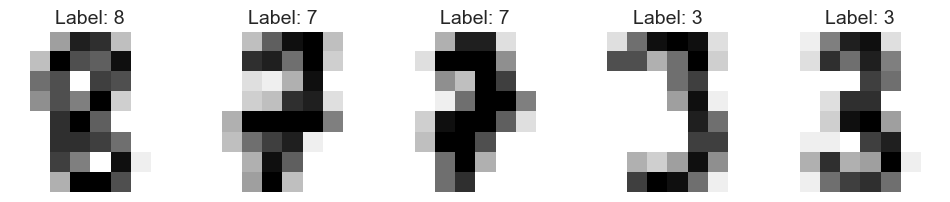

In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [3]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method, plot_test_results, ridge_loss_method
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam

from jax import jit, nn, grad, device_get
import jax.numpy as jnp

# Make feature matrix. We flatten each image and use these 64 values as our input layer
X = inputs.reshape((inputs.shape[0], 64))

# Convert the numbers in y to arrays with 0's and 1's corresponding to classes 
y = labels.reshape((labels.shape[0]))
y = np.eye(10)[y]

# Split in test and train
X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=None)

# Make prediction function:
def predict(model, beta, X):
    """
    Returns the predicted number for each sample in X
    """

    # Use the neural network
    y = model(beta, X)

    # Find best guess index
    predictions = jnp.array([jnp.argmax(y_sample) for y_sample in y])

    return predictions


# Define new accuracy function
def accuracy_method(model):
    """
    Returns function for evaluating accuracy for given model
    ACCURACY = percentage guessed correctly    
    """

    def accuracy_func(beta, X, y):

        # Find indeces corresponding to ground truth
        predictions_gt = jnp.array([jnp.argmax(y_sample) for y_sample in y])
        predictions    = predict(model, beta, X)

        # return 1-jnp.mean(jnp.abs(predictions_gt-predictions))
        return jnp.sum(predictions_gt == predictions) / predictions.shape[0]

    return accuracy_func

### Single run

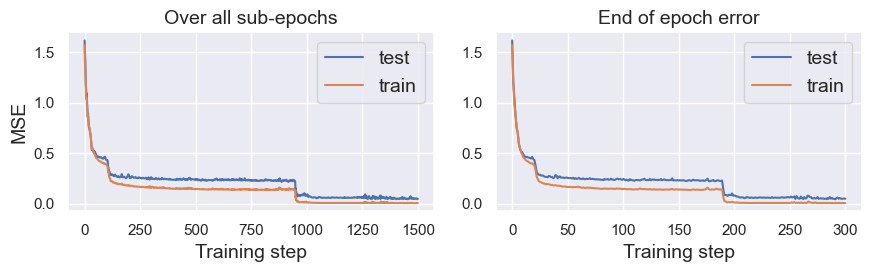

test:  0.97214484
train:  0.9972184


In [44]:
from Code.softmax_regression import softmax_beta_init, softmax_model
import jax as jax

def softmax_beta_init(input_shape, output_shape):
    """
    Input:
        input_shape: num features
        output_shape: num classes
    Returns:
        xavier initialised weights
    """

    return _beta_init([input_shape, output_shape])


def softmax_model(beta, X):
    # Weighted sum of input + bias
    out = jnp.dot(X.copy(), beta[f"W1"]) + beta[f"b1"]

    # Softmax to get probabilities TODO: MULIG SLICINGA FUCKER OPP
    out = jnp.exp(out) / jnp.sum(jnp.exp(out), axis=-1)[:, None]

    return out


def single_run(X, z, lr, lam, epochs=300, test_index=None, plot_or_not=False):
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X.shape[1], output_shape=y.shape[1])
    # model = jit(softmax_model)
    model = softmax_model


    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))
    test_funcs = [test_func]

    # Split the dataset.
    X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2, test_index=test_index)

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, 
                      test_loss_func= test_funcs, lr=lr)
    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"][0], result["train_loss_list"][0], 5, ylabel="MSE")

    # Add accuracy scores
    result["test_accuracy"] = accuracy_method(model)(result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_method(model)(result["beta_final"], X_train, y_train)

    # Also store the model for later use
    result["model"] = model

    return result

epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, epochs=epochs, test_index=test_index, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])